# MLP  simple 1024 neuronas de entrada

### Librerias comunes a todas las redes usadas

In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import os 
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import random as python_random
from sklearn.metrics import roc_curve
import splitfolders
from pathlib import Path
from PIL import Image
import pathlib
import itertools
import pandas as pd

2.6.0


### Librerias Particulares para esta Red Neuronal:  MLP

In [2]:
from keras.models import Sequential
from keras.layers import Dense,Flatten

### Fijar las semillas pseudoaleatorias para reproductibilidad de los modelos

In [3]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

### Variables generales

In [4]:
tamaño_imagen=224
IMG_SIZE = (tamaño_imagen, tamaño_imagen) #28
shape=[tamaño_imagen,tamaño_imagen]
epocas=20
modelo_nombre='mlp1024'
umbral=0.5  # 0.5   Variar umbral cambia criterio Positivo o negativo
input_folder = 'dataset'  
output_folder= 'dividido'
modelos_folder='modelos/'
train_dir = output_folder+"/train/"
val_dir = output_folder+"/val/"
test_dir = output_folder+"/test/"
ratio_entreno=0.8
ratio_val=0.1
ratio_test=0.1
colores='grayscale' #  alternativa   colores='rgb'

### Funciones de ayuda

In [5]:
def cargar_ejemplos():
    P_image = Image.open(input_folder+'/P/0p.jpg')
    N_image = Image.open(input_folder+'/N/0n.jpg')
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.xlabel('P  (MonkeyPox)')
    plt.imshow(P_image)
    plt.subplot(1,2,2)
    plt.xlabel('N  (Sano)')
    plt.imshow(N_image)

In [6]:
def divide_dataset(origen,destino,entrena_ratio,val_ratio,test_ratio):
    if entrena_ratio+val_ratio+test_ratio==1:
         if not(Path(destino).is_dir()):
            splitfolders.ratio(origen, output= destino, seed=1337, ratio = (entrena_ratio,val_ratio,test_ratio))
    else:  
        print ("Error en los ratios, deben sumar 1")

In [7]:
def cambia_extension(path1):
    contador=0
    for dirs in os.listdir(path1):
        path2=path1+'/'+dirs
        for subdir in os.listdir(path2):
            path3=path2+'/'+subdir
            for files in os.listdir(path3):
                filename, extension = os.path.splitext(files)
                if extension==".jfif":
                    contador+=1
                    os.rename(path3+'/'+files, path3+'/'+filename+str(contador)+'.jpg')
    print("Se han cambiado las extensiones de: ", contador)

In [8]:
def generar_trenes_datos(train_dir,colores,IMG_SIZE):
    train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 color_mode=colores,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                 shuffle=True
                                                                 )
    val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                     color_mode=colores,
                                                                     image_size=IMG_SIZE,
                                                                     label_mode="binary",
                                                                     batch_size=32,
                                                                     shuffle=True
                                                                     )
    test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                     color_mode=colores,
                                                                     image_size=IMG_SIZE,
                                                                     label_mode="binary",
                                                                     batch_size=1,
                                                                     shuffle=False
                                                                     )
    return train_data, val_data, test_data

In [9]:
def muestra_ejemplos_datos_trenes(nombre_tren):
    class_names = nombre_tren.class_names
    print("Las clases detectadas en el tren de datos, son: ",class_names)
    plt.figure(figsize=(10, 10))
    for images, labels in nombre_tren.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int((labels[i]).numpy())])  
        plt.axis("off")

In [10]:
def muestra_imagen_test(nombre_tren):
    class_names = nombre_tren.class_names
    plt.figure(figsize=(5, 5))
    for images, labels in nombre_tren.take(1):
        ax = plt.subplot(1, 1, 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(class_names[int((labels[0]).numpy())])  
        plt.axis("off")

In [11]:
def datos_trenes_analisis(path_analisis):
    directorio = pathlib.Path(path_analisis)
    directorios = [fichero.name for fichero in directorio.iterdir() if fichero.is_dir()]
    isfile = os.path.isfile 
    join = os.path.join 
    numero_de_ficheros=[]
    for cuenta,carpeta in enumerate(directorios):
        numero_de_ficheros.append ( sum(1 for item in os.listdir(path_analisis+carpeta) if isfile(join(path_analisis+carpeta, item))))
    #numero_de_ficheros= [x-1  for x in numero_de_ficheros]
    print("Análisis del directorio: ",path_analisis )
    print( "Categorías  y nº de muestras:\n",*zip(directorios,numero_de_ficheros))
    #  matplot lib para mostrar un grafico de sectores balance de clases
    plt.figure(figsize=(7,3))
    colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
    plt.rcParams.update({'font.size': 14})
    plt.pie(numero_de_ficheros,
            labels=directorios,
            colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
            startangle=30);
    plt.title("Balance de clases: "+path_analisis )
    return numero_de_ficheros

### Funciones de ayuda creadas para evaluar los modelos

In [12]:
def evalua_modelo(modelo):
    #Evaluacion del modelo
    scores=modelo.evaluate(train_data,verbose=True)
    print("Precisión de entrenamiento: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(val_data,verbose=True)
    print("Precisión de validacion: %.1f%%\n"%(scores[1]*100))
    scores=modelo.evaluate(test_data,verbose=True)
    print("Precisión de prueba: %.1f%%\n"%(scores[1]*100))

In [13]:
def evalua2(modelo,umbral):
    # umbrales del modelo, por redondeo porque sigmoid devuelve un valor entre 0 y 1    
    #y_pred = tf.math.round(modelo.predict(test_data))
    # umbrales del modelo, por entrada de usuario (umbral)
    y_pred = tf.where(modelo.predict(test_data) < umbral, 0, 1)
    y_true = []
    for images, labels in test_data.unbatch():
        y_true.append(labels.numpy())
    y_true=[int(y_true[x][0]) for x in range(len(y_true))]
    
    print('La precisión sobre el conjunto de test, es:',accuracy_score(y_true, y_pred))
    print('Las metricas principales son:')
    print(classification_report(y_true, y_pred, target_names=test_data.class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm.astype("int"), annot=True)
    #Curva Roc
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curva')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return cm

In [14]:
def plot_confusion_matrix(cm, classes, title='Matriz de Confusión'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Etiqueta')
    plt.xlabel('Predicha Etiqueta')
    plt.show()


In [15]:
def guarda_modelo(modelo):
    modelo.save(modelos_folder+modelo_nombre+'.h5')
    print("Modelo guardado como: ",modelo_nombre+'.h5')

In [16]:
def guarda_history(modelo):
    df=pd.DataFrame(modelo.history)
    df.plot(figsize=(8,5))
    plt.show()
    df.to_csv(modelos_folder+modelo_nombre+'.csv', sep=';')
    print("History guardado como: ",modelo_nombre+'.csv')

In [17]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

#  Ejecutar programa

# A - Tratamiento previo del dataset

### 1. Cargar imágenes 

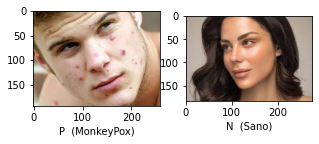

In [18]:
cargar_ejemplos()

###  2.- Dividir el dataset en entrenamiento + Validación + test <p>
Esta función lo hace, pero antes comprueba que no esté ya hecho, para no repetir el proceso.

In [19]:
divide_dataset(input_folder,output_folder,ratio_entreno, ratio_val, ratio_test)

### 3.- Corregir extensiones no compatible

El dataset original contiene ficheros con extensiones tipo '.jfif', que No son reconocidas por train_generator como imágenes<p>
Esta pequeña función renombra esas extensiones a jpg que sí son compatibles, de este modo operará con el dataset completo en número de imágenes disponibles

In [20]:
cambia_extension(output_folder)

Se han cambiado las extensiones de:  0


 ###  Antes  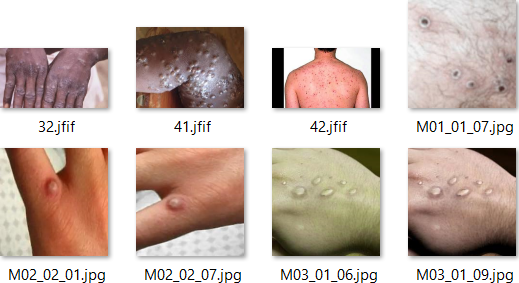

# Despues    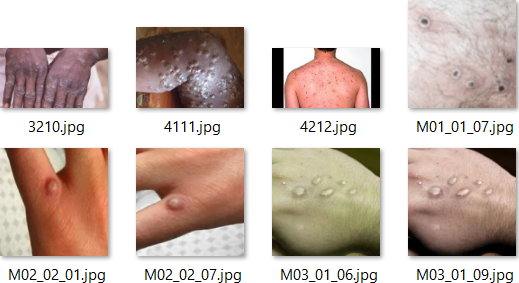

### 4.- Carga de Datos

In [21]:
train_data, val_data, test_data=generar_trenes_datos(train_dir,colores,IMG_SIZE)

Found 3104 files belonging to 2 classes.
Found 387 files belonging to 2 classes.
Found 390 files belonging to 2 classes.


#### Se comprueba visualmente que ha generado trenes de datos  y se visualizan algunas muestras  (train_data  o val_data)

Las clases detectadas en el tren de datos, son:  ['N', 'P']


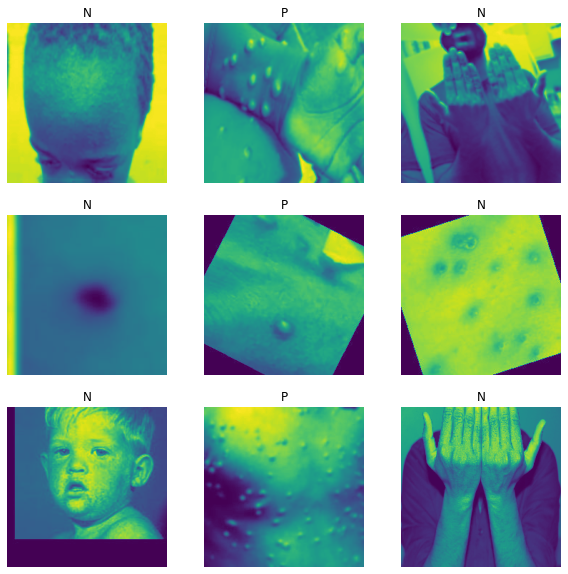

In [22]:
muestra_ejemplos_datos_trenes(train_data)

Análisis del directorio:  dividido/train/
Categorías  y nº de muestras:
 ('N', 1895) ('P', 1211)
Análisis del directorio:  dividido/val/
Categorías  y nº de muestras:
 ('N', 236) ('P', 151)
Análisis del directorio:  dividido/test/
Categorías  y nº de muestras:
 ('N', 238) ('P', 152)


[238, 152]

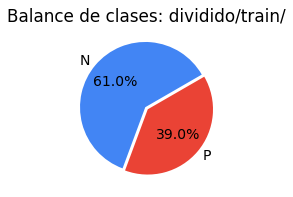

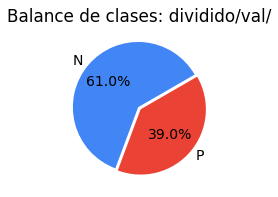

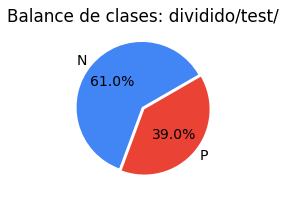

In [23]:
weights=datos_trenes_analisis(train_dir)
datos_trenes_analisis(val_dir)
datos_trenes_analisis(test_dir)

# B - Definicion del tercer modelo MLP

* **Sequential**: Eso define una SECUENCIA de capas en la red neuronal
* **Dense**: Añade una capa de neuronas
* **Flatten** Convierte una matriz bidimensional en un vector de una dimensión.

Cada capa de neuronas necesita una función de activación. Normalmente se usa la función relu en las capas intermedias y softmax (multiclase)  o sigmoid (binario) en la ultima capa
* **Relu** significa que "Si X>0 devuelve X, si no, devuelve 0", así que lo que hace es pasar sólo valores 0 o mayores a la siguiente capa de la red.
* **Softmax** toma un conjunto de valores, y escoge el más grande.
* **Sigmoid**, devuelve valoes entre 0 y 1

#### * Una, hidden layer de tamaños 1024, utilizando unidades relu
#### * Dos, hidden layer de tamaños 128, utilizando unidades relu
Optimizador Adam.
* Durante el entrenamiento, la red tiene que mostrar resultados de loss y accuracy por cada epoch.
* La red debe entrenar durante 20 epochs y batch size de 64.
* La última capa debe de ser una capa sigmoid


### 5.- Modelar la Red Neuronal

In [24]:
mlp1024 = Sequential()
mlp1024.add(Flatten(input_shape=shape))
mlp1024.add(Dense(1024, activation='relu'))
mlp1024.add(Dense(128, activation='relu'))
mlp1024.add(Dense(1, activation='sigmoid'))
opt = tf.optimizers.Adam(learning_rate=0.01)
mlp1024.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 6.- Entrenar la Red

In [25]:
history_mlp1024 = mlp1024.fit(train_data,
                       epochs=epocas,batch_size=64,verbose=True,shuffle=False,
                       validation_data=val_data)
mlp1024.summary()

Epoch 1/20
97/97 [==============================] - 8s 68ms/step - loss: 16329.1367 - accuracy: 0.5345 - val_loss: 37.6208 - val_accuracy: 0.5659
Epoch 2/20
97/97 [==============================] - 7s 66ms/step - loss: 95.8493 - accuracy: 0.5499 - val_loss: 12.6352 - val_accuracy: 0.3876
Epoch 3/20
97/97 [==============================] - 7s 67ms/step - loss: 139.0275 - accuracy: 0.5155 - val_loss: 0.7115 - val_accuracy: 0.3902
Epoch 4/20
97/97 [==============================] - 7s 68ms/step - loss: 66.0679 - accuracy: 0.5119 - val_loss: 0.6671 - val_accuracy: 0.6124
Epoch 5/20
97/97 [==============================] - 7s 69ms/step - loss: 0.6688 - accuracy: 0.6105 - val_loss: 0.6668 - val_accuracy: 0.6124
Epoch 6/20
97/97 [==============================] - 7s 68ms/step - loss: 0.6688 - accuracy: 0.6105 - val_loss: 0.6667 - val_accuracy: 0.6124
Epoch 7/20
97/97 [==============================] - 7s 68ms/step - loss: 0.6688 - accuracy: 0.6105 - val_loss: 0.6664 - val_accuracy: 0.6124
Epo

### 7.- Guardar el modelo ya entrenado

In [26]:
guarda_modelo(mlp1024)

Modelo guardado como:  mlp1024.h5


### 8.- Evaluar modelo

In [27]:
evalua_modelo(mlp1024)

97/97 [==============================] - 2s 22ms/step - loss: 0.6700 - accuracy: 0.6105
Precisión de entrenamiento: 61.1%

13/13 [==============================] - 0s 18ms/step - loss: 0.6683 - accuracy: 0.6124
Precisión de validacion: 61.2%

390/390 [==============================] - 3s 8ms/step - loss: 0.6696 - accuracy: 0.6077
Precisión de prueba: 60.8%



La precisión sobre el conjunto de test, es: 0.6076923076923076
Las metricas principales son:
              precision    recall  f1-score   support

           N       0.61      1.00      0.76       238
           P       0.00      0.00      0.00       152

    accuracy                           0.61       390
   macro avg       0.30      0.50      0.38       390
weighted avg       0.37      0.61      0.46       390



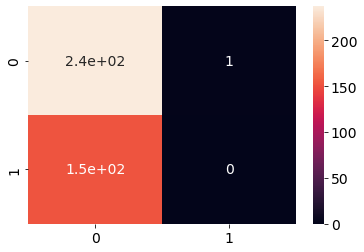

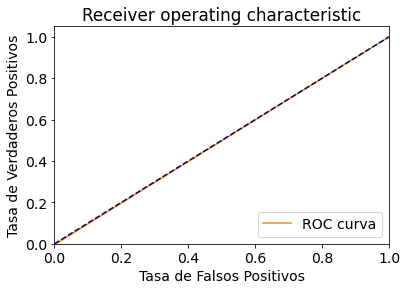

In [28]:
cm=evalua2(mlp1024,umbral)

Resultados  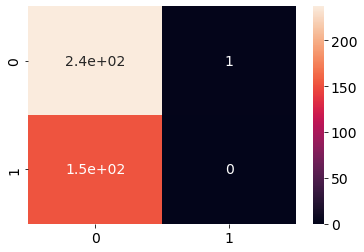    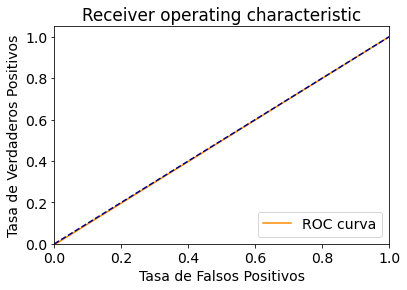

### matriz confusión en colores azules

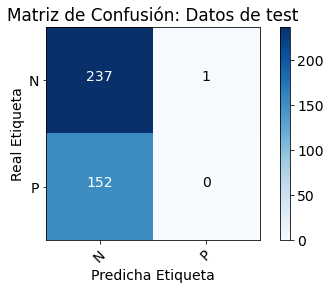

In [29]:
plot_confusion_matrix(cm, test_data.class_names, title='Matriz de Confusión: Datos de test')

Resultados     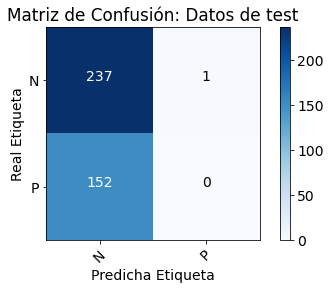

### Variando el umbral   0.25

La precisión sobre el conjunto de test, es: 0.3923076923076923
Las metricas principales son:
              precision    recall  f1-score   support

           N       1.00      0.00      0.01       238
           P       0.39      1.00      0.56       152

    accuracy                           0.39       390
   macro avg       0.70      0.50      0.29       390
weighted avg       0.76      0.39      0.22       390



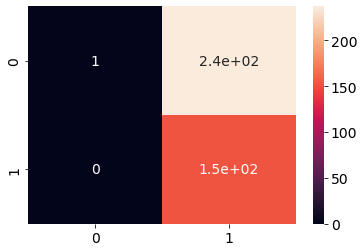

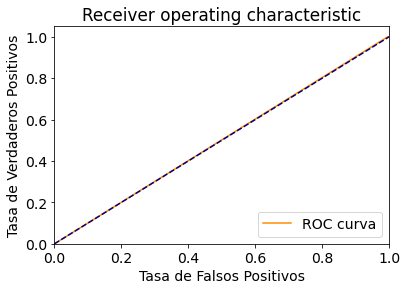

In [30]:
umbral=0.4
cm=evalua2(mlp1024,umbral)

### 9.- Curvas métricas de entrenamiento

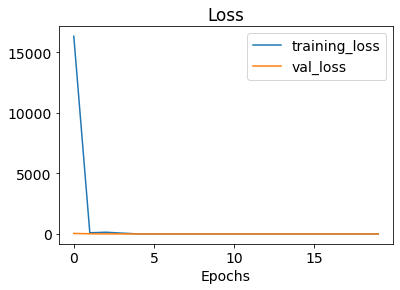

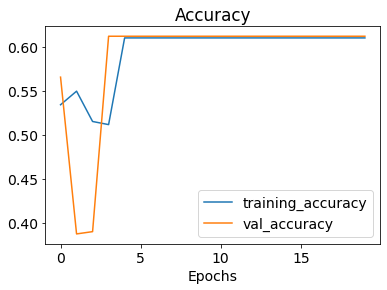

In [31]:
plot_loss_curves(history_mlp1024)

Resultados  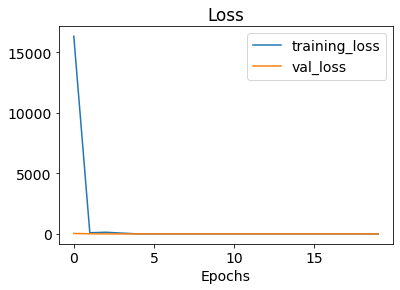   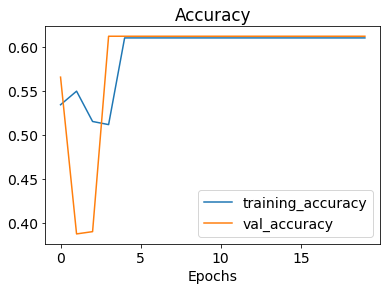

### Guarda el historial

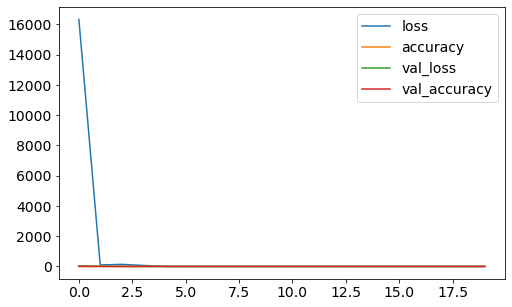

History guardado como:  mlp1024.csv


In [32]:
guarda_history(history_mlp1024)

###  10.- Comprobar visualmente las predicciones 

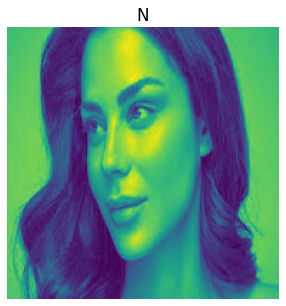

In [33]:
muestra_imagen_test(test_data)

In [34]:
umbral=0.5
classifications= mlp1024.predict(test_data)
resultados=["N" if x<umbral else "P" for x in classifications]
print("Predicción de la imagen de prueba: ",classifications[0], resultados[0],"\n")


Predicción de la imagen de prueba:  [0.4191531] N 

